In [17]:
using JuMP, NamedArrays, PyPlot, Gurobi

In [18]:
WIDTH = 51 # odd number
HEIGHT = 41 # odd number
NRG = min(WIDTH, HEIGHT)

# Declare Request type
type Request
    pickup_pos::Tuple{Int64, Int64}
    pickup_time::Int
    dropoff_pos::Tuple{Int64, Int64}
    duration::Int
end

# Declare Depot type
type Depot
    cur_pos::Tuple{Int64, Int64}
end

In [19]:
# Function: calculate Manhattan distance
function manhattan_distance(a, b)
    return sum(abs.([i for i in a]-[i for i in b]))
end

# Function: generate uniformly distributed locations
function rand_uniform_xy()
   return (rand(1:WIDTH), rand(1:HEIGHT)) 
end

# # Function: generate Gaussian distributed locations
# function rand_Gaussian_xy()
#     pass_x = Int(round((randn()/6+0.5)*(NRG-1)+1))
#     pass_y = Int(round((randn()/6+0.5)*(NRG-1)+1))
#     if WIDTH > HEIGHT
#         pass_x += Int(round((WIDTH-HEIGHT)/2))
#     else
#         pass_y += Int(round((HEIGHT-WIDTH)/2))
#     end
#     return (pass_x, pass_y)
# end

rand_uniform_xy (generic function with 1 method)

In [43]:
# Function: generate a map with requests and deopt
function genGrid(n_req, n_depot)
    requests = Request[]
    depot = Depot[]
    ptime = sort(rand(50:500,n_req))
    for i=1:n_req
        ppos = rand_uniform_xy()
        dpos = rand_uniform_xy()
        p = Request(ppos, ptime[i], dpos, manhattan_distance(ppos,dpos))
        push!(requests, p)
    end
    for i=1:n_depot
        d = Depot((Int((WIDTH+1)/2), Int((HEIGHT+1)/2)))
        push!(depot, d)
    end
    plot_request_depot(requests, depot)   #### Function call to plot 
    for i=1:length(requests)
        println(i, ": ", requests[i])
    end
    return requests,depot
end

genGrid (generic function with 1 method)

In [42]:
# Function: plot requests and deopt on a map
function plot_request_depot(requests, depot)
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[]  # depot position x
    dys = Int64[]  # depot position y
    
    fig = figure(figsize=(15,15*(HEIGHT/WIDTH)))
    #fig = figure()
    ax = axes()
    for i=1:length(requests)
        p = requests[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.2,fontweight="bold",fontsize=12)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.2,fontweight="bold",fontsize=12)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(depot)
        d = depot[i]
        annotate("Depot", xy=[a for a in d.cur_pos]-0.6,fontweight="bold",fontsize=9)
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    scatter(ppxs,ppys,s=300,alpha=0.5,color="g", marker="D")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="r", marker = "X")
    scatter(dxs,dys,s=1200,alpha=0.5,color="b", marker = "s")
    title("Map")
    xlabel("X")
    #xlim([1,WIDTH])
    ylabel("Y")
    #ylim([1,HEIGHT])
    legend(["Pickup","Drop-off","Depot"],bbox_to_anchor=(0., 1.02, 1., .102), loc=2,
           ncol=4, mode="expand", borderaxespad=0.)
    grid("on")
end


plot_request_depot (generic function with 1 method)

In [44]:
# Function: create a plot showing the request with the time window
function plot_Request_Time_Window(requests)
    
    #figure(figsize=(10,10));
    figure()
    request_no = length(requests)
    drop_time_list = []

    for i=1:request_no
        p = requests[i]
        drop_time = p.pickup_time+p.duration
        push!(drop_time_list, drop_time)
        
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        hlines(y=i, xmin=p.pickup_time, xmax=drop_time, color=color_val,lw=3)
        plot(p.pickup_time, i, marker="o", color=color_val)
        plot(drop_time, i, marker="o", color=color_val)
        
        time_stamp = string("T = ", p.pickup_time)
        text(p.pickup_time, i + 0.1, time_stamp, fontsize=10,fontweight="bold")
        time_stamp = string("T = ", drop_time)
        text(drop_time, i - 0.2, time_stamp, fontsize=10,fontweight="bold") 
    end

    PyPlot.yticks(1:request_no)
    ax = gca()
    ax[:set_xlim](requests[1].pickup_time - 10, maximum(drop_time_list) + 20)
    ax[:set_ylim]([0, request_no + 1])
    title("Request Time Windows")
    xlabel("Time")
    ylabel("Request #")
    grid("on")
end

plot_Request_Time_Window (generic function with 1 method)

In [23]:
# # Function: generate distance matrix
function distance_matrix(nodes, numReq)
    
    # Creating names for nodes
    points = []
    i = 0
    push!(points,"Depot")
    for r in 1:numReq
        i = i+1
        pickup = string("P_",i)
        drop = string("D_",i)
        push!(points,pickup)
        push!(points,drop)
    end
    #println(numReq)
    println(points)

    # Compute distance matrix for the Agencies
    pointA = nodes
    pointB = copy(nodes)

    nodeLen = length(nodes) # nodes include pickup, dropoff and depot

    D = zeros(nodeLen,nodeLen)

    for j = 1:nodeLen
        for i = 1:nodeLen
            D[i, j] = abs(pointA[j][1] - pointB[i][1]) + abs(pointA[j][2] - pointB[i][2])
        end
    end
    #println("Distance matrix : ",D)
    println("")

    dist_matrix = NamedArray(D,(points,points),("From","To"))
    #show(IOContext(STDOUT, displaysize=(2000, 2000)), dist_matrix)
    #points
    return dist_matrix
end

distance_matrix (generic function with 1 method)

In [24]:
# Function: get the coordinates of all depot and pickup, drop locations of requests (in order of request)
# Can be modified to be called within distance matrix
function getLocations(depot, requests)
    nodes = []
    for d in depot             # Right now, considering only single depot.
        depot_node = d.cur_pos
        push!(nodes, depot_node)
    end

    for r in requests
        push!(nodes, r.pickup_pos)
        push!(nodes, r.dropoff_pos)
    end
    return nodes
end

getLocations (generic function with 1 method)

In [25]:
# Function: assign random request times for each request
function assign_pickup_time(startT, requests)
    endT = startT + 200 +  50*length(requests)
    ptime = sort(rand(startT:endT, length(requests)))
    #println(ptime)
    k = 1
    for r in requests
        r.pickup_time = ptime[k]
        k = k + 1
    end
    return requests
end

assign_pickup_time (generic function with 1 method)

In [45]:
# Function: plot car routes
function plot_car_route(requests, depot, mask)    
    
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[]  # depot position x
    dys = Int64[]  # depot position y
    fig = figure(figsize=(15,15*(HEIGHT/WIDTH)))
    ax = axes()
    for i=1:length(requests)
        p = requests[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.2,fontweight="bold",fontsize=12)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.2,fontweight="bold",fontsize=12)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(depot)
        d = depot[i]
        annotate("Depot", xy=[a for a in d.cur_pos]-0.6,fontweight="bold",fontsize=9)
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    
    scatter(ppxs,ppys,s=300,alpha=0.5,color="g", marker="D")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="r", marker = "X")
    scatter(dxs,dys,s=1000,alpha=0.5,color="b", marker = "s")
    legend(["Pickup","Drop-off","Depot"],bbox_to_anchor=(0., 1.02, 1., .102), loc=2,
           ncol=4, mode="expand", borderaxespad=0.)
    # Plot route line for each cab
    for k = 1:K
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        for p = 1:2R+1
            for d = 1:2R+1

                if mask[p, d, k] > 0.5 # Make sure drawing routes only when mask == 1
                    if p+1 == d && p%2 == 0
                        request = requests[Int8(round(p/2))]

                        pp_x = request.pickup_pos[1]
                        pp_y = request.pickup_pos[2]
                        dp_x = request.dropoff_pos[1]
                        dp_y = request.dropoff_pos[2]
                        
                        hlines(y=pp_y, xmin=pp_x, xmax=dp_x, color=color_val, lw=5)
                        vlines(x=dp_x, ymin=pp_y, ymax=dp_y, color=color_val, lw=5)
                    else
                        if p == 1 # from depot
                            end_between_req = requests[Int8(round(d/2))]

                            pp_x = depot[1].cur_pos[1]
                            pp_y = depot[1].cur_pos[2]
                            dp_x = end_between_req.pickup_pos[1]
                            dp_y = end_between_req.pickup_pos[2]
                            
                            x_min = minimum([pp_x, dp_x])
                            x_max = maximum([pp_x, dp_x])
                            x_range = x_min:x_max; y_range = pp_y*ones(length(x_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 1)

                            y_min = minimum([pp_y, dp_y])
                            y_max = maximum([pp_y, dp_y])
                            y_range = y_min:y_max; x_range = dp_x*ones(length(y_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 1)
                        elseif d == 1 # from depot
                            start_between_req = requests[Int8(round((p-1)/2))]

                            pp_x = start_between_req.dropoff_pos[1]
                            pp_y = start_between_req.dropoff_pos[2]   
                            dp_x = depot[1].cur_pos[1]
                            dp_y = depot[1].cur_pos[2]
                            
                            x_min = minimum([pp_x, dp_x])
                            x_max = maximum([pp_x, dp_x])
                            x_range = x_min:x_max; y_range = pp_y*ones(length(x_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 1)

                            y_min = minimum([pp_y, dp_y])
                            y_max = maximum([pp_y, dp_y])
                            y_range = y_min:y_max; x_range = dp_x*ones(length(y_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 1)                            
                        else # between requests
                            start_between_req = requests[Int8(round((p-1)/2))]
                            end_between_req = requests[Int8(round(d/2))]

                            pp_x = start_between_req.dropoff_pos[1]
                            pp_y = start_between_req.dropoff_pos[2]   
                            dp_x = end_between_req.pickup_pos[1]
                            dp_y = end_between_req.pickup_pos[2]
                            
                            x_min = minimum([pp_x, dp_x])
                            x_max = maximum([pp_x, dp_x])
                            x_range = x_min:x_max; y_range = pp_y*ones(length(x_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 3)

                            y_min = minimum([pp_y, dp_y])
                            y_max = maximum([pp_y, dp_y])
                            y_range = y_min:y_max; x_range = dp_x*ones(length(y_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 3)
                        end
                    end
                    
                    time_stamp = string("[Cab #", k, "]")
                    if dp_y > pp_y
                        plot(dp_x, dp_y, marker="^", color=color_val, markersize = 18)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val,style = "italic")
                    elseif dp_y < pp_y
                        plot(dp_x, dp_y, marker="v", color=color_val, markersize = 18)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val,style = "italic")
                    elseif dp_y == pp_y && dp_x < pp_x
                        plot(dp_x, dp_y, marker="<", color=color_val, markersize = 18)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val,style = "italic")
                    elseif dp_y == pp_y && dp_x > pp_x
                        plot(dp_x, dp_y, marker=">", color=color_val, markersize = 18)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val,style = "italic")
                    end
                end
                
            end
        end
    end
    
    title("Cab Route for Requests")
    xlabel("X");#xlim([1,WIDTH])
    ylabel("Y");#ylim([1,HEIGHT])
    grid("on")
end

plot_car_route (generic function with 1 method)

In [46]:
# Function: generate requests
function generate_requests(R)
    # Generate all input data
    requests, depot = genGrid(R, 1)
    
    # Get Location coordinates.
    nodes = getLocations(depot, requests)

    # Compute distance matrix
    dist_map = distance_matrix(nodes, length(requests));

    # Find max distance from the depot to a pickup and use it as the reference time to start the TimeSlots for requests
    maxDistFromDepot = maximum(dist_map[:,1])

    # Now, assign random time slots beginning from maxDistFromDepot to all requests.
    requests = assign_pickup_time(maxDistFromDepot, requests)
    
    plot_Request_Time_Window(requests)   # Calling this function here coz of modified slots.

    p_t = []
    p_l = []
    d_t = []
    d_l = []
    duration = []

    println("")
    for r = 1:R
        push!(p_t, requests[r].pickup_time)
        push!(p_l, requests[r].pickup_pos)
        push!(d_t, requests[r].pickup_time + requests[r].duration)
        push!(d_l, requests[r].dropoff_pos)
        push!(duration, requests[r].duration)
    end
    #println("")
    #println("pickup time = ", p_t)
    #println("pickup location = ", p_l)
    #println("dropoff time = ", d_t)
    #println("dropoff location = ", d_l)
    #println("duration = ", duration)
    return requests, depot, dist_map, p_t, p_l, d_t, d_l, duration
end

generate_requests (generic function with 1 method)

In [47]:
# Function: optmize VRP model
function optmize_VRP_model(requests, depot, dist_map, p_t, p_l, d_t, d_l, duration, R, K, lambda, limit = 0)
    
    Big_M = sum(dist_map)
    Big_M2 = R*R
    small_m = minimum(p_t) - maximum(d_t) - maximum(dist_map)
    small_m2 = 0
    small_m3 = -1
    epsilon = 1
    
    
    m = Model(solver=GurobiSolver(OutputFlag=0))

    @variable(m, y[1:K], Bin)                          # if the cab is dispatched or not
    @variable(m, x[1:R, 1:K], Bin)                     # if the request is assigned to the cab or not
    @variable(m, mask[1:2R+1, 1:2R+1, 1:K], Bin)       # Given one cab, if the node p to node d is connected or not
    @variable(m, more_equal_2[1:R, 1:R, 1:K], Bin)     # summation >= 2 -> more_equal_2 is true
    @variable(m, less_equal_2[1:R, 1:R, 1:K], Bin)     # summation <= 2 -> less_equal_2 is true
    @variable(m, equal_2[1:R, 1:R, 1:K], Bin)          # summation == 2 -> equal_2 is true
    @variable(m, two_req[1:R, 1:R, 1:K], Bin)          # both requests assigned to the same cab -> two_req is true
    @variable(m, more_equal_1_for_sum1[1:R, 1:K], Bin) # sum1 >= 1 <-> more_equal_1_for_sum1 is true
    @variable(m, less_equal_1_for_sum2[1:R, 1:K], Bin) # sum2 <= 1 <-> less_equal_1_for_sum2 is true
    @variable(m, more_equal_1_for_sum3[1:R, 1:K], Bin) # sum3 >= 1 <-> more_equal_1_for_sum3 is true
    @variable(m, less_equal_1_for_sum4[1:R, 1:K], Bin) # sum4 <= 1 <-> less_equal_1_for_sum4 is true

    @expression(m, d[k in 1:K], sum(dist_map[p, d] * mask[p, d, k] for p in 1:2R+1, d in 1:2R+1)) # Express the total travel distance of each cab
    @expression(m, sum1[r in 1:R, k in 1:K], sum(x[i,k] for i in 1:r))    # summation from the index 1 to i of x
    @expression(m, sum2[r in 1:R, k in 1:K], sum(sum1[i,k] for i in 1:r)) # summation from the index 1 to i of sum1 
    @expression(m, sum3[r in 1:R, k in 1:K], sum(x[i,k] for i in r:R))    # summation from the index 1 to i of x
    @expression(m, sum4[r in 1:R, k in 1:K], sum(sum3[i,k] for i in r:R)) # summation from the index R to i of sum3

    if limit != 0            # Each car can only carry limited number of requests
        for i in 1:K
            @constraint(m, sum(x[j,i] for j in 1:R) <= limit)
        end
    end
    
    # Connect route from depot to first pickup location for each cab
    for k = 1:K
        for r = 1:R
            @constraint(m, sum1[r,k] - 1 <= R*more_equal_1_for_sum1[r,k] - epsilon*(1-more_equal_1_for_sum1[r,k])) 
            @constraint(m, sum1[r,k] - 1 >= small_m3*(1-more_equal_1_for_sum1[r,k]))
            @constraint(m, sum2[r,k] - 1 >= small_m3*less_equal_1_for_sum2[r,k] + epsilon*(1-less_equal_1_for_sum2[r,k]))
            @constraint(m, sum2[r,k] - 1 <= Big_M2*(1-less_equal_1_for_sum2[r,k]))
        end
        for r = 1:R
            @constraint(m, mask[1, 2*r, k] - 1 >= small_m3*(1 - more_equal_1_for_sum1[r,k]*less_equal_1_for_sum2[r,k]))
        end
    end

    # Connect route from last dropoff location to depot for each cab
    for k = 1:K
        for r = 1:R
            @constraint(m, sum3[r,k] - 1 <= R*more_equal_1_for_sum3[r,k] - epsilon*(1-more_equal_1_for_sum3[r,k])) 
            @constraint(m, sum3[r,k] - 1 >= small_m3*(1-more_equal_1_for_sum3[r,k]))
            @constraint(m, sum4[r,k] - 1 >= small_m3*less_equal_1_for_sum4[r,k] + epsilon*(1-less_equal_1_for_sum4[r,k]))
            @constraint(m, sum4[r,k] - 1 <= Big_M2*(1-less_equal_1_for_sum4[r,k]))
        end
        for r = 1:R
            @constraint(m, mask[2*r+1, 1, k] - 1 >= small_m3*(1 - more_equal_1_for_sum3[r,k]*less_equal_1_for_sum4[r,k]))
        end
    end

    # Connect route between two consecutive requests assigned to each cab 
    for r1 = 1:R-1
        for r2 = (r1+1):R
            for k = 1:K
                @constraint(m, sum(x[r1:r2,k])-2 <= (R-2)*more_equal_2[r1, r2, k]-(1-more_equal_2[r1, r2, k]))
                @constraint(m, sum(x[r1:r2,k])-2 >= (-2)*less_equal_2[r1, r2, k]+(1-less_equal_2[r1, r2, k]))
                @constraint(m, equal_2[r1, r2, k] - 1 >= small_m3*(1-more_equal_2[r1, r2, k]*less_equal_2[r1, r2, k]))
                @constraint(m, two_req[r1, r2, k] - 1 >= small_m3*(1 - (x[r1, k]*x[r2, k])))
                @constraint(m, mask[2*r1+1, 2*r2, k] - 1 >= small_m3*(1 - equal_2[r1, r2, k]*two_req[r1, r2, k]))
            end
        end
    end

    # Connect route from pickup to dropoff locations for each request
    for r = 1:R
        for k = 1:K
            # if x[r, k] == 1 => mask[2r, 2r+1, k] == 1
            @constraint(m, mask[2r, 2r+1, k] - 1 >= small_m3*(1 - x[r, k]))
        end
    end

    # Must dispatch one cab to each request
    @constraint(m, constraint1[r in 1:R], sum(x[r, k] for k =1:K) == 1)

    # Dispatch cabs from the smallest number
    for k = 1:K
        if k < K
            @constraint(m, y[k] >= y[k+1])
        end
    end

    # A dispatched cab must travel for some distance > 0
    for k = 1:K
        @constraint(m, d[k] <= Big_M * y[k])    
        @constraint(m, d[k] >= small_m2 * (1 - y[k]) + epsilon*y[k])
    end

    # Make sure that a cab can complete two requests in time if they are assigned to it
    for r1 = 1:R-1
        for r2 = (r1+1):R
            for k = 1:K
                @constraint(m, p_t[r2] - d_t[r1] - dist_map[2*r2, 2*r1+1] >= small_m*(1 - x[r1, k]*x[r2, k]))
            end
        end
    end

    # At most 1 cab can be assigned to each travel route between 2 nodes
    for p_idx in 1:2R+1
        for d_idx in 1:2R+1
            @constraint(m, sum(mask[p_idx, d_idx, k] for k in 1:K) <= 1)
        end
    end

    # Given one cab and one starting node, at most one ending node can be assigned
    for k = 1:K
        for p_idx in 1:2R+1
            @constraint(m, sum(mask[p_idx, d_idx, k] for d_idx in 1:2R+1) <= 1)
        end
    end

    # Minimize the sum of (the number of dispatched cabs + the total travel distances by dispatched cabs)
    @objective(m, Min, sum(lambda*y + d))

    time = @time(status = solve(m))
    println("")

    if status != :Optimal
        println("\n", Status,"\nCheck the parameters again...")
    else
        println("Optimal solution: ")
        println("- objective_best = ", getobjectivevalue(m))
        println("- y_best = ", getvalue(y))
        println("- x_best = ")
        for r = 1:R
            println(getvalue(x)[r, 1:K])
        end
        mask_best = getvalue(mask)
        """println("- mask_best = ")
        for k = 1:K
            for p_idx in 1:2R+1
                println(mask_best[p_idx, 1:2R+1, k])
            end
            println("")
        end"""
        println("- d_best = ", getvalue(d))
        plot_car_route(requests, depot, mask_best)
        return getvalue(y), getvalue(d)
    end
end

optmize_VRP_model (generic function with 2 methods)

In [48]:
# Function: build up a VRP model
function VRP_model(R, K, lambda, limit = 0)
    requests, depot, dist_map, p_t, p_l, d_t, d_l, duration = generate_requests(R)
    y_best, d_best = optmize_VRP_model(requests, depot, dist_map, p_t, p_l, d_t, d_l, duration, R, K, lambda, limit)
end

VRP_model (generic function with 2 methods)

# VRP Model Test

# Start calling functions here :

1: Request((4, 6), 127, (26, 5), 23)
2: Request((34, 5), 133, (19, 15), 25)
3: Request((1, 1), 164, (36, 12), 46)
4: Request((9, 32), 242, (29, 28), 24)
5: Request((13, 18), 343, (11, 29), 13)
6: Request((2, 16), 387, (23, 12), 25)
Any["Depot", "P_1", "D_1", "P_2", "D_2", "P_3", "D_3", "P_4", "D_4", "P_5", "D_5", "P_6", "D_6"]




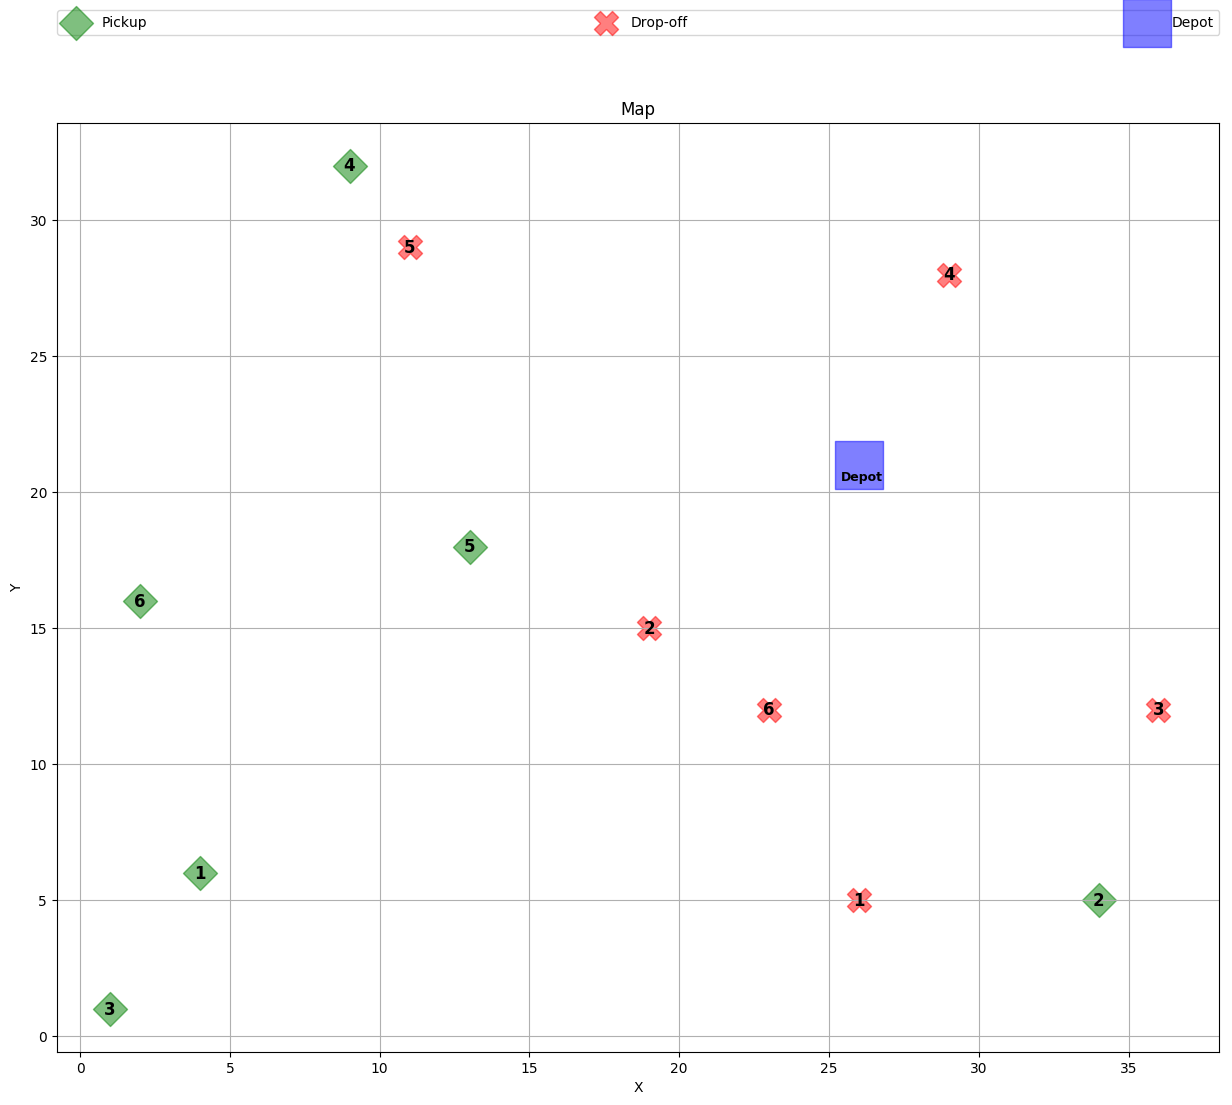

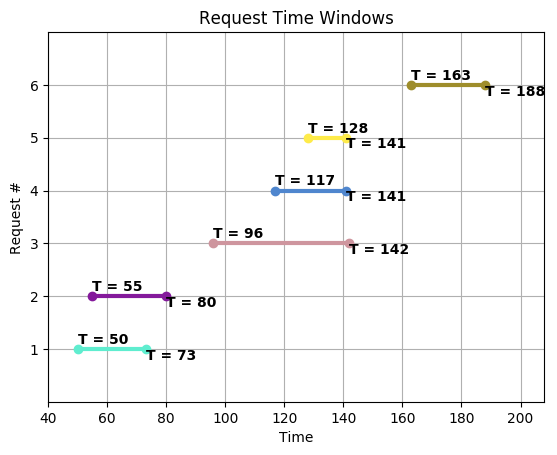

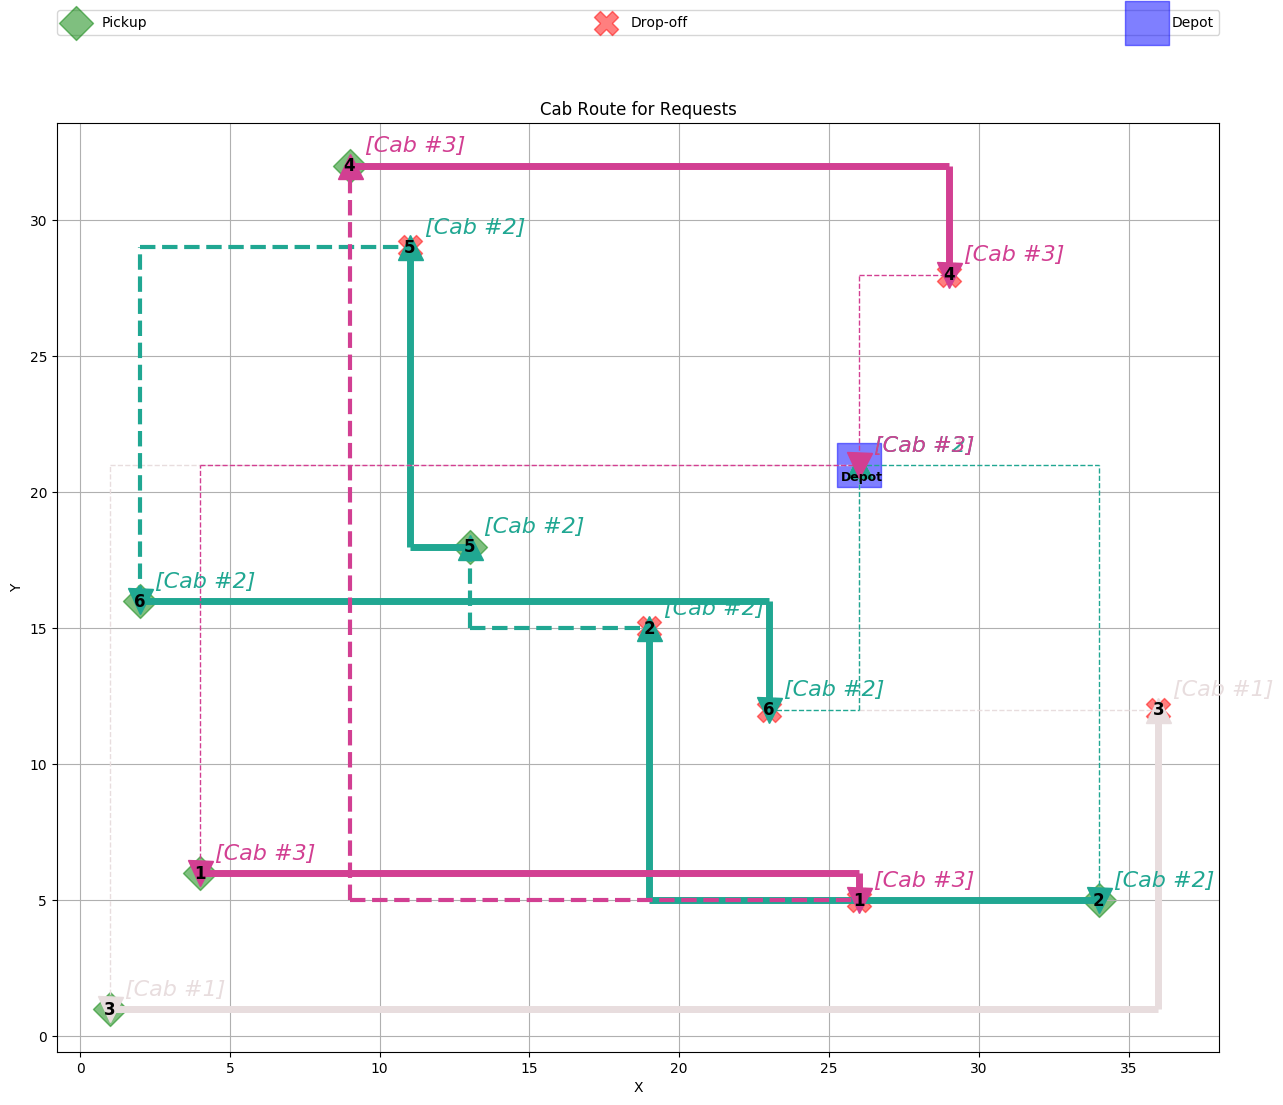

Academic license - for non-commercial use only
  0.305048 seconds (5.34 k allocations: 1.166 MiB)

Optimal solution: 
- objective_best = 30378.0
- y_best = [1.0, 1.0, 1.0, -0.0, -0.0, -0.0]
- x_best = 
[-0.0, -0.0, 1.0, -0.0, -0.0, -0.0]
[-0.0, 1.0, -0.0, -0.0, -0.0, -0.0]
[1.0, -0.0, -0.0, -0.0, -0.0, -0.0]
[-0.0, -0.0, 1.0, -0.0, -0.0, -0.0]
[-0.0, 1.0, -0.0, -0.0, -0.0, -0.0]
[-0.0, 1.0, -0.0, -0.0, -0.0, -0.0]
- d_best = [110.0, 130.0, 138.0, 0.0, 0.0, 0.0]


([1.0, 1.0, 1.0, -0.0, -0.0, -0.0], [110.0, 130.0, 138.0, 0.0, 0.0, 0.0])

In [49]:
# Scenerio setting
R = 6 # Number of requests
K = R # Number of cabs
lambda = 10000 # Weighting of the cab number for objective

# Scenario 1
VRP_model(R, K, lambda)   # Call VRP Model No limit on requests served by each cab.

1: Request((32, 38), 110, (11, 37), 22)
2: Request((43, 6), 160, (31, 13), 19)
3: Request((4, 35), 216, (31, 17), 45)
4: Request((11, 5), 338, (4, 13), 15)
5: Request((19, 40), 367, (16, 13), 30)
6: Request((8, 25), 438, (45, 15), 47)
Any["Depot", "P_1", "D_1", "P_2", "D_2", "P_3", "D_3", "P_4", "D_4", "P_5", "D_5", "P_6", "D_6"]




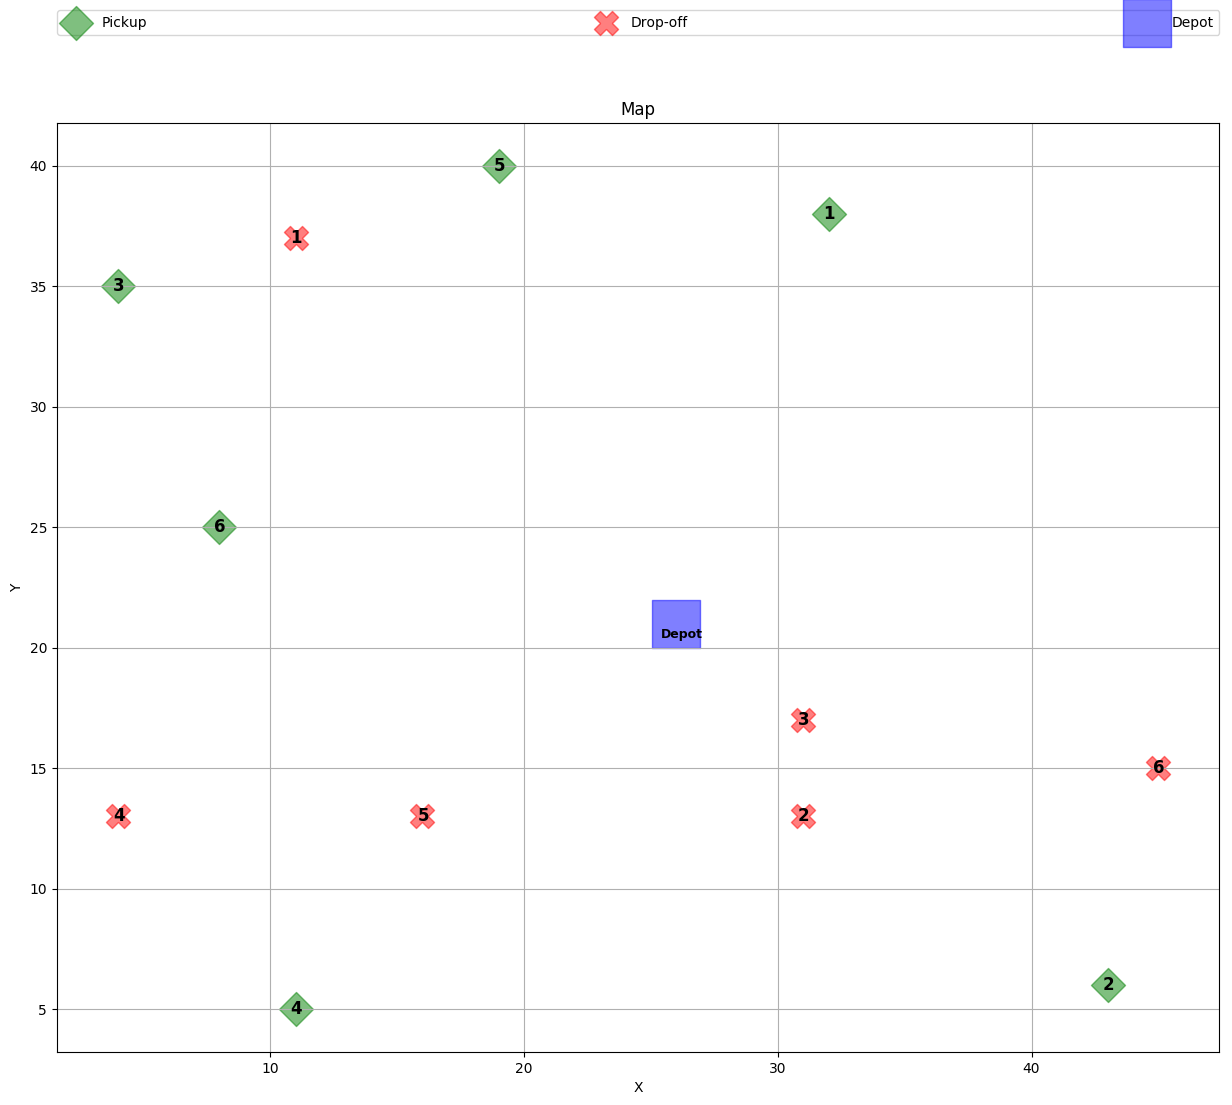

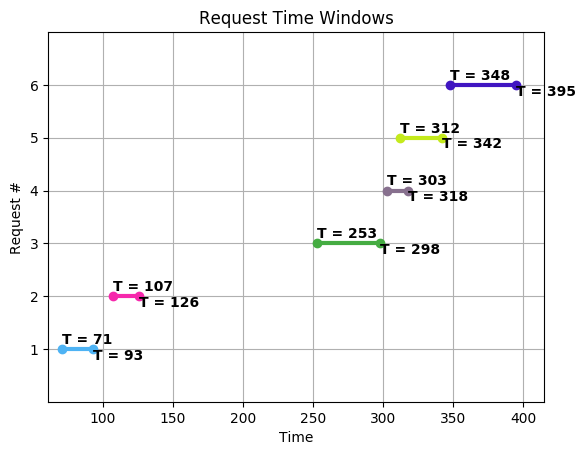

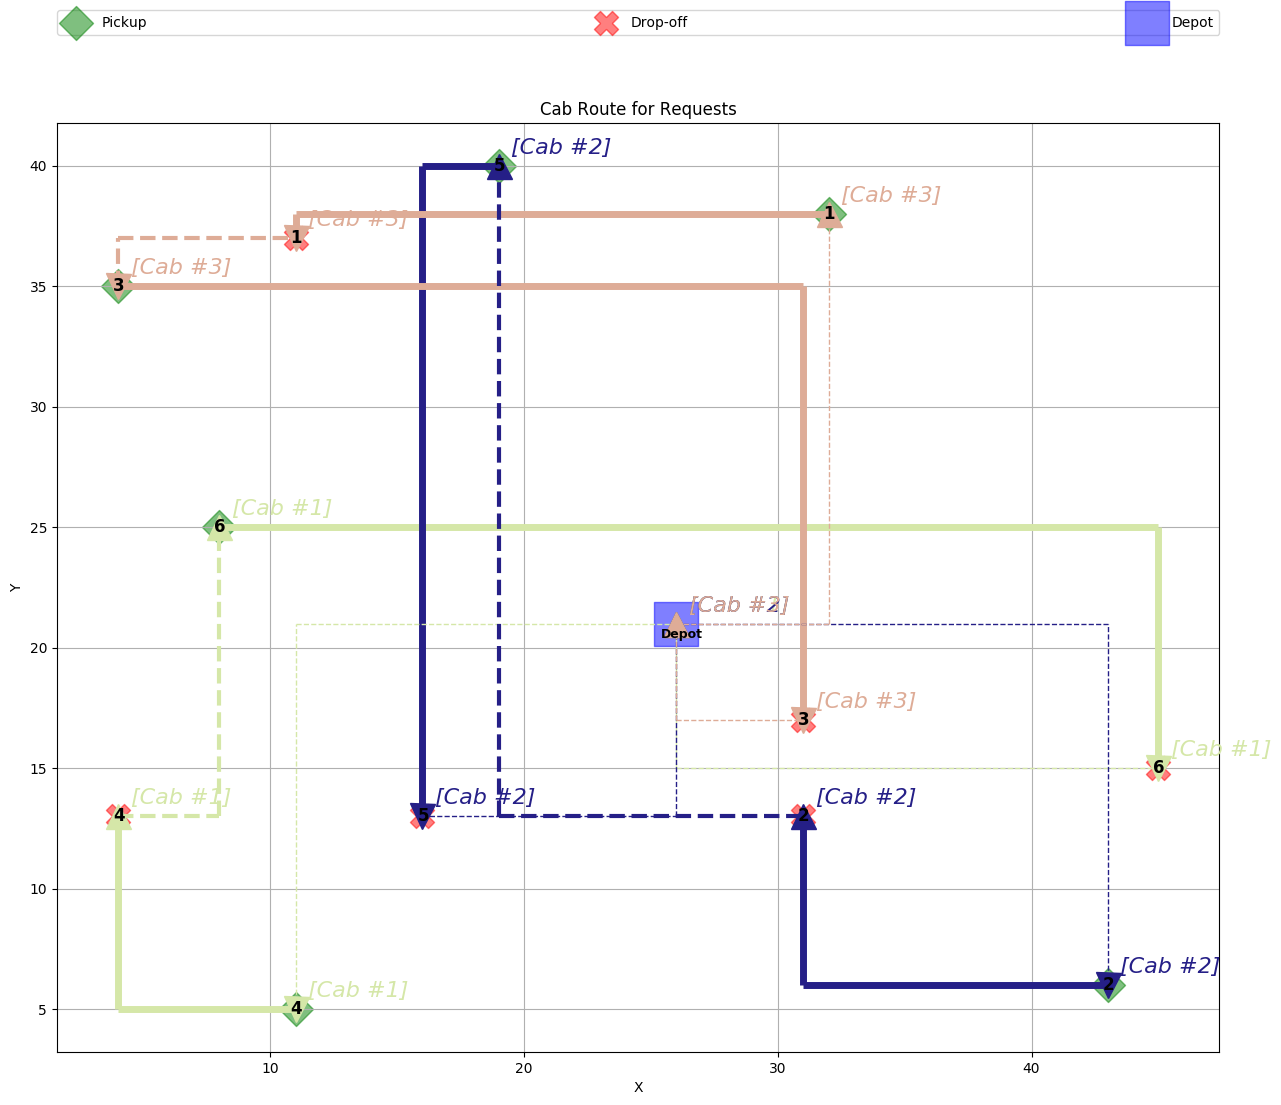

Academic license - for non-commercial use only
  0.231810 seconds (5.34 k allocations: 1.170 MiB)

Optimal solution: 
- objective_best = 30380.0
- y_best = [1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
- x_best = 
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[-0.0, -0.0, 1.0, 0.0, 0.0, 0.0]
[1.0, -0.0, -0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
- d_best = [134.0, 138.0, 108.0, 0.0, 0.0, 0.0]


([1.0, 1.0, 1.0, 0.0, 0.0, 0.0], [134.0, 138.0, 108.0, 0.0, 0.0, 0.0])

In [50]:
# Scenario 2
VRP_model(R, K, lambda,2) # Limit on the requests served by each car

1: Request((40, 16), 71, (49, 27), 20)
2: Request((30, 1), 179, (18, 8), 19)
3: Request((20, 25), 321, (43, 10), 38)
4: Request((37, 29), 338, (20, 26), 20)
5: Request((44, 22), 465, (9, 7), 50)
6: Request((16, 21), 488, (15, 31), 11)
Any["Depot", "P_1", "D_1", "P_2", "D_2", "P_3", "D_3", "P_4", "D_4", "P_5", "D_5", "P_6", "D_6"]


Academic license - for non-commercial use only
  0.224181 seconds (5.34 k allocations: 1.166 MiB)

Optimal solution: 
- objective_best = 20300.0
- y_best = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
- x_best = 
[2.22045e-16, 1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
- d_best = [216.0, 84.0, 0.0, 0.0, 0.0, 0.0]


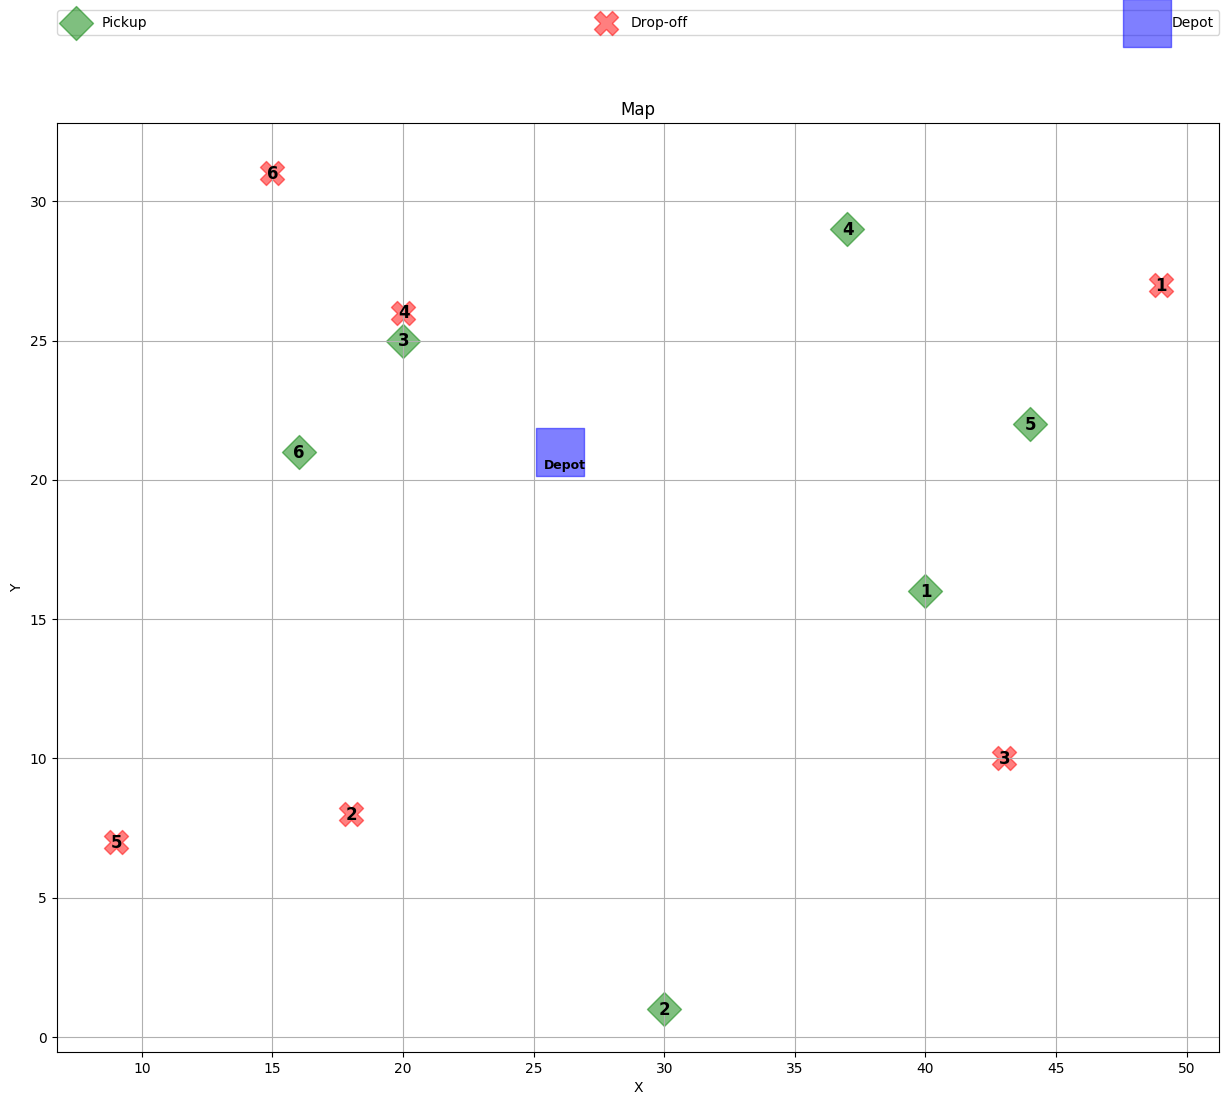

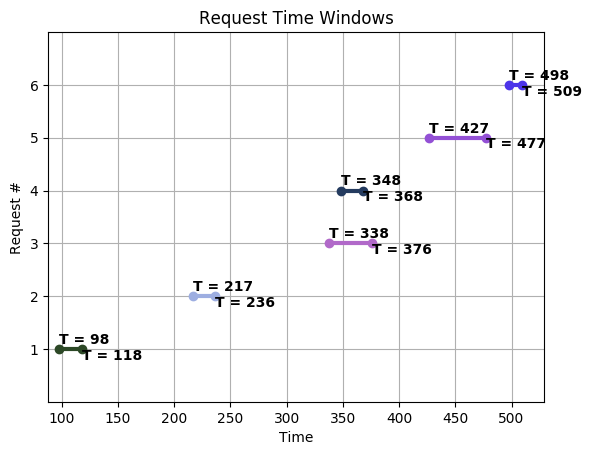

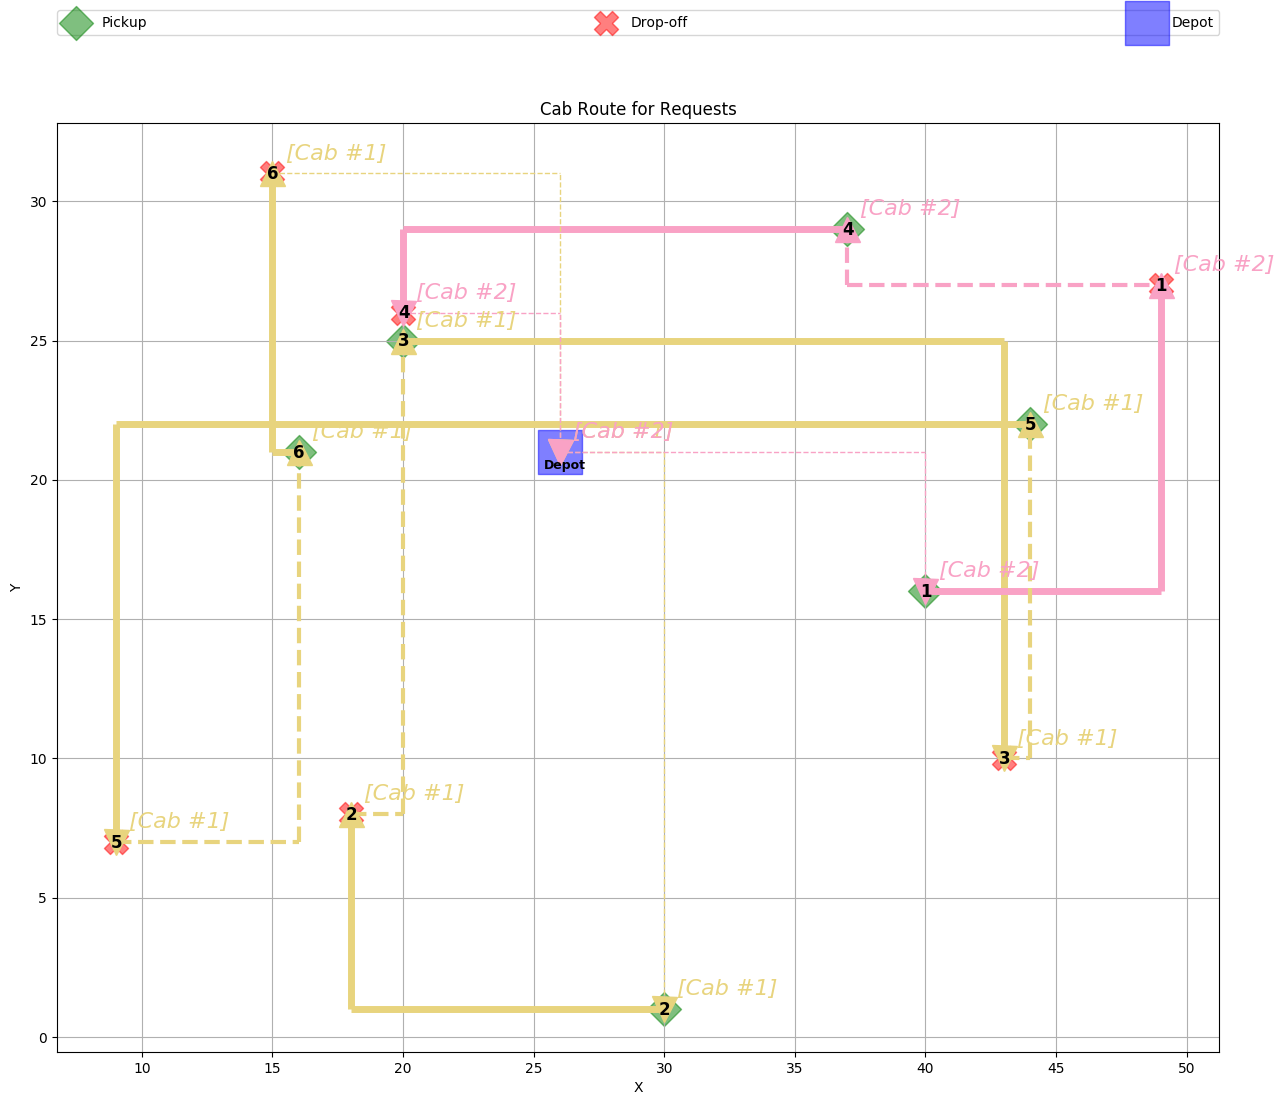

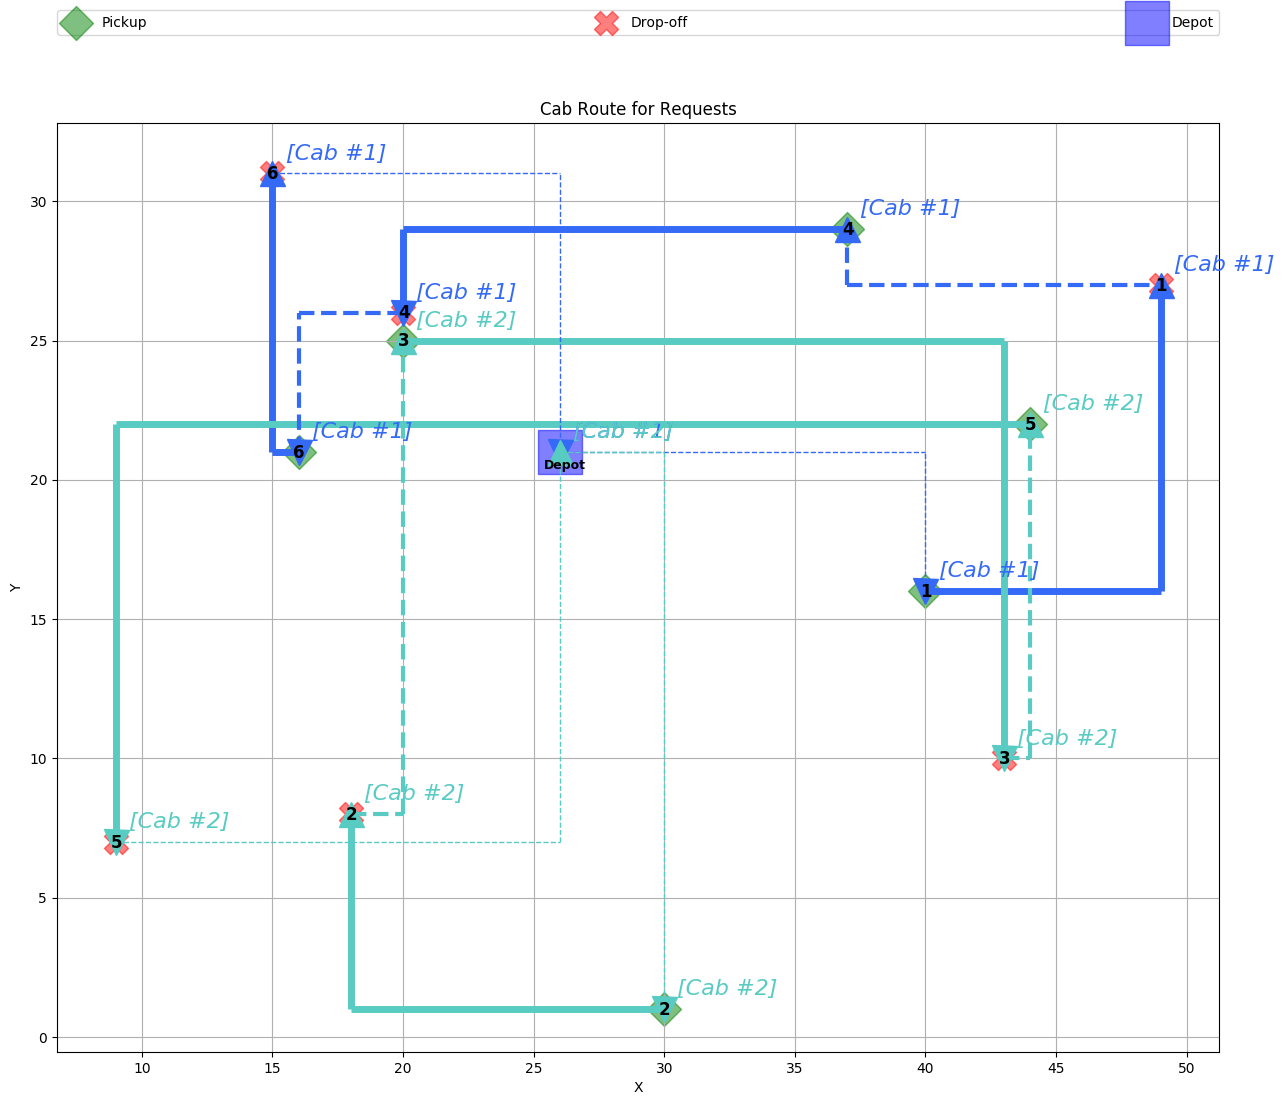

Academic license - for non-commercial use only
  0.224038 seconds (5.34 k allocations: 1.170 MiB)

Optimal solution: 
- objective_best = 20308.0
- y_best = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
- x_best = 
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
- d_best = [114.0, 194.0, 0.0, 0.0, 0.0, 0.0]


([1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [114.0, 194.0, 0.0, 0.0, 0.0, 0.0])

In [51]:
# Scenario 3
# Generating the same request for both contrained and unconstrained requests served by the cabs
requests, depot, dist_map, p_t, p_l, d_t, d_l, duration = generate_requests(R)
    
y_best1, d_best1 = optmize_VRP_model(requests, depot, dist_map, p_t, p_l, d_t, d_l, duration, R, K, lambda)
y_best2, d_best2 = optmize_VRP_model(requests, depot, dist_map, p_t, p_l, d_t, d_l, duration, R, K, lambda, 3)

# Drawing a Pareto Curve


1: Request((7, 9), 117, (27, 5), 24)
2: Request((2, 14), 381, (14, 33), 31)
3: Request((34, 22), 432, (33, 38), 17)
Any["Depot", "P_1", "D_1", "P_2", "D_2", "P_3", "D_3"]



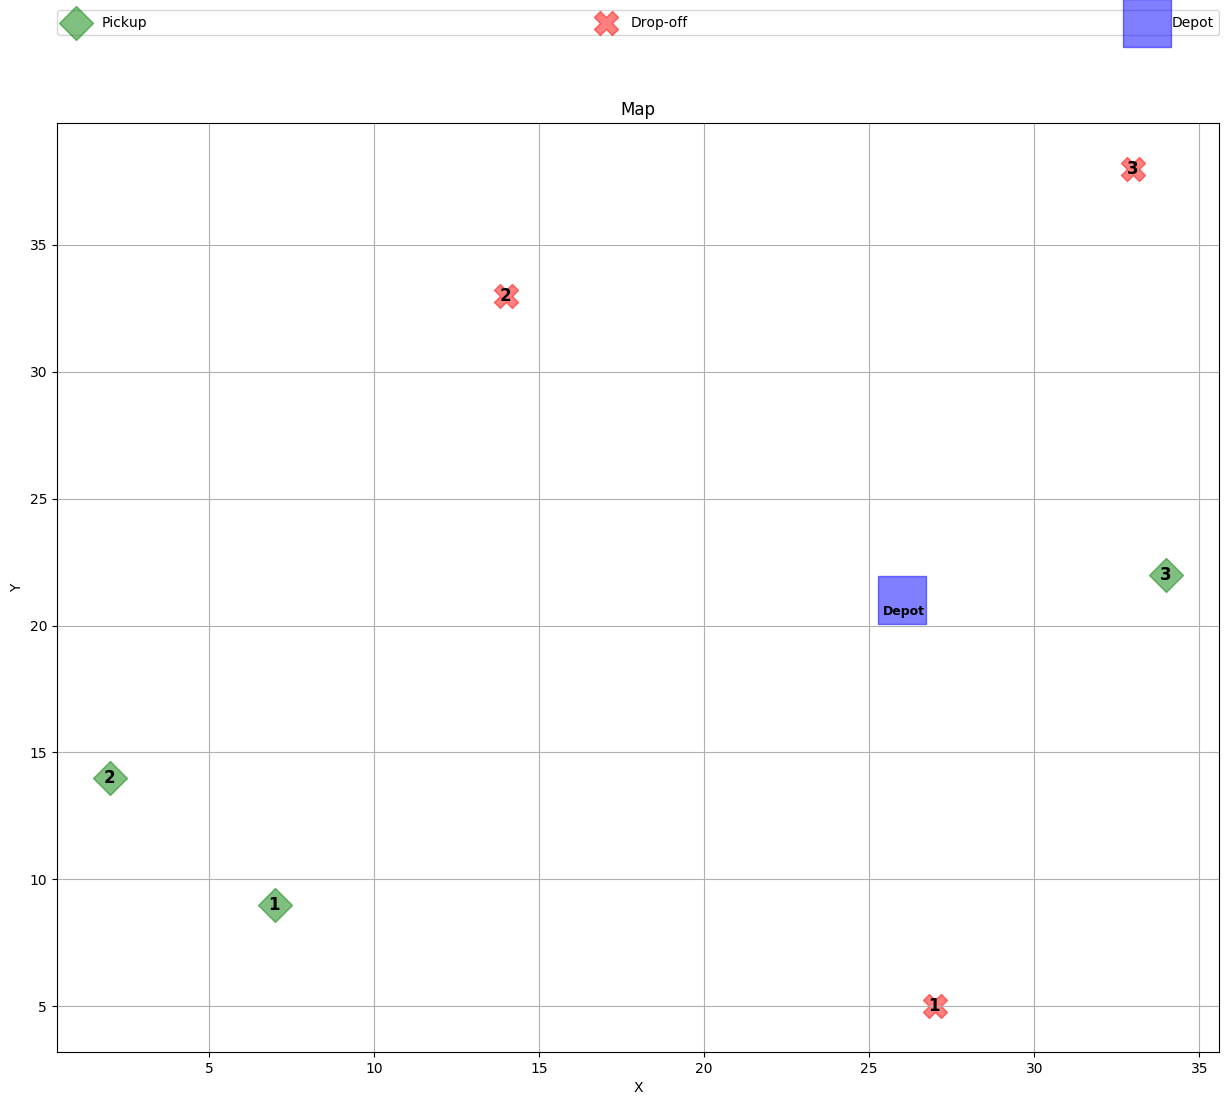

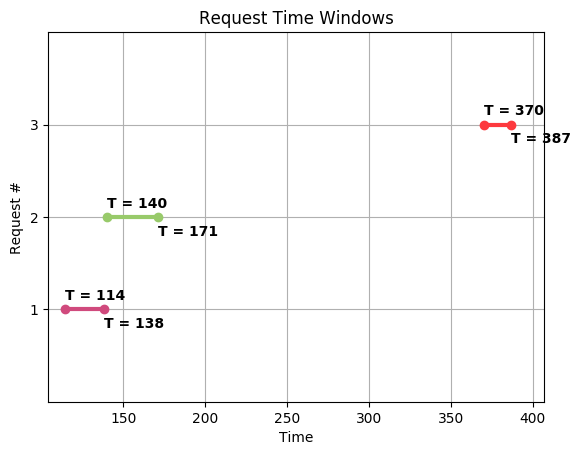

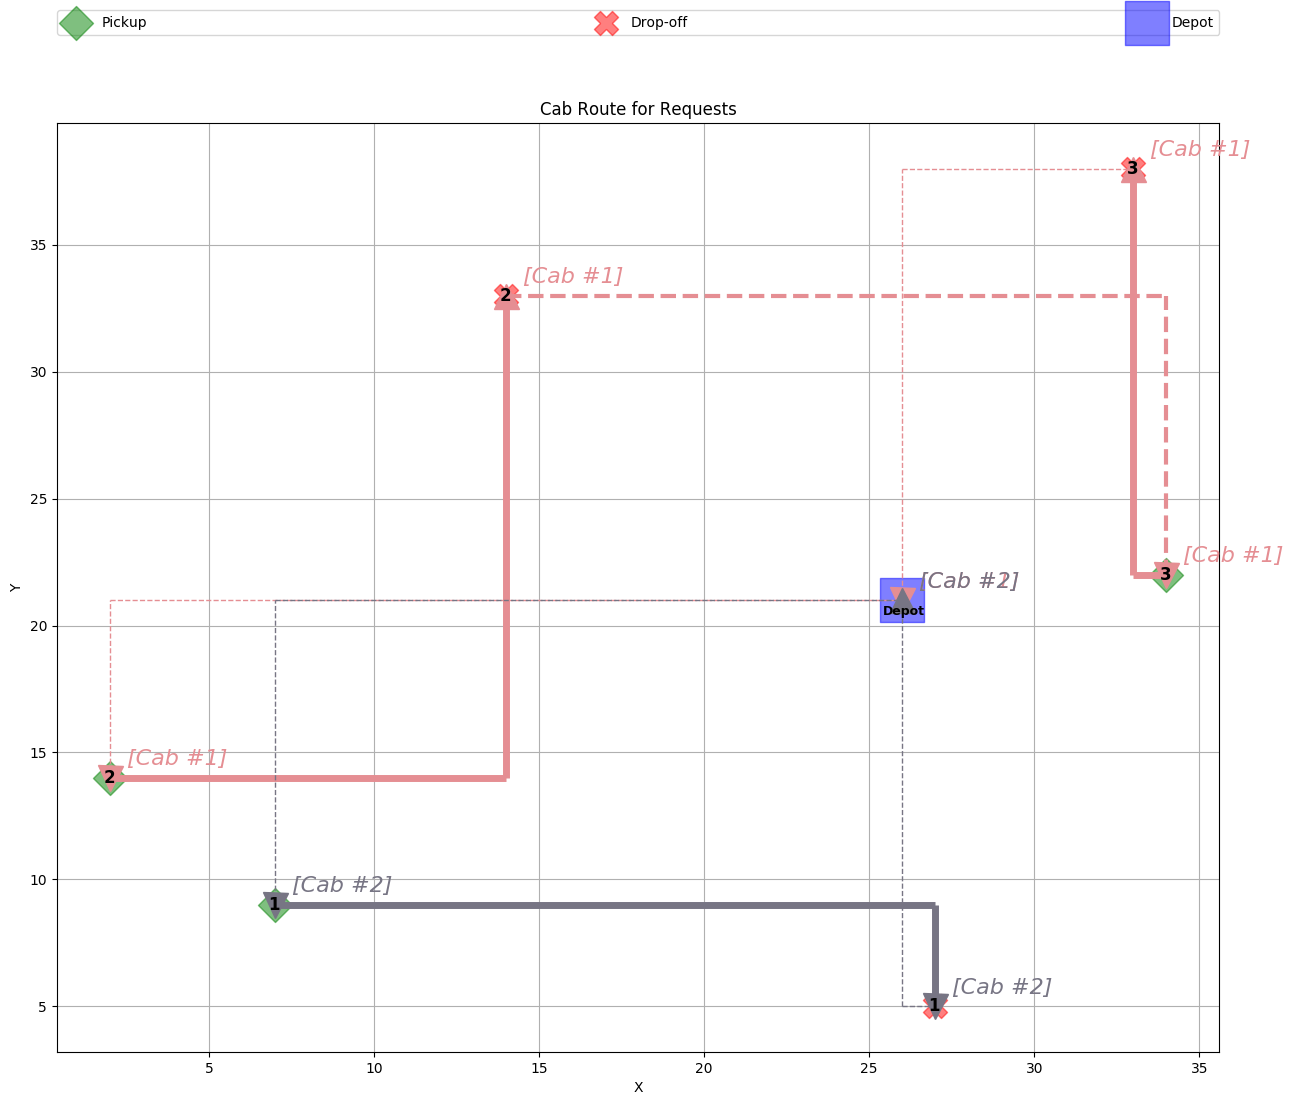


Academic license - for non-commercial use only
  0.048337 seconds (771 allocations: 179.828 KiB)

Optimal solution: 
- objective_best = 206.0
- y_best = [1.0, 1.0, 0.0]
- x_best = 
[0.0, 1.0, 0.0]
[1.0, 0.0, 0.0]
[1.0, 0.0, 0.0]
- d_best = [134.0, 72.0, 0.0]


(Request[Request((7, 9), 114, (27, 5), 24), Request((2, 14), 140, (14, 33), 31), Request((34, 22), 370, (33, 38), 17)], Depot[Depot((26, 21))])

In [161]:
# For drawing a pareto curve
# Scenerio setting
R = 3 # Number of requests
K = R # Number of cabs
lambda = 0 # Weighting of the cab number for objective

requests, depot, dist_map, p_t, p_l, d_t, d_l, duration = generate_requests(R)
y_best, d_best = optmize_VRP_model(requests, depot, dist_map, p_t, p_l, d_t, d_l, duration, R, K, lambda)
requests, depot

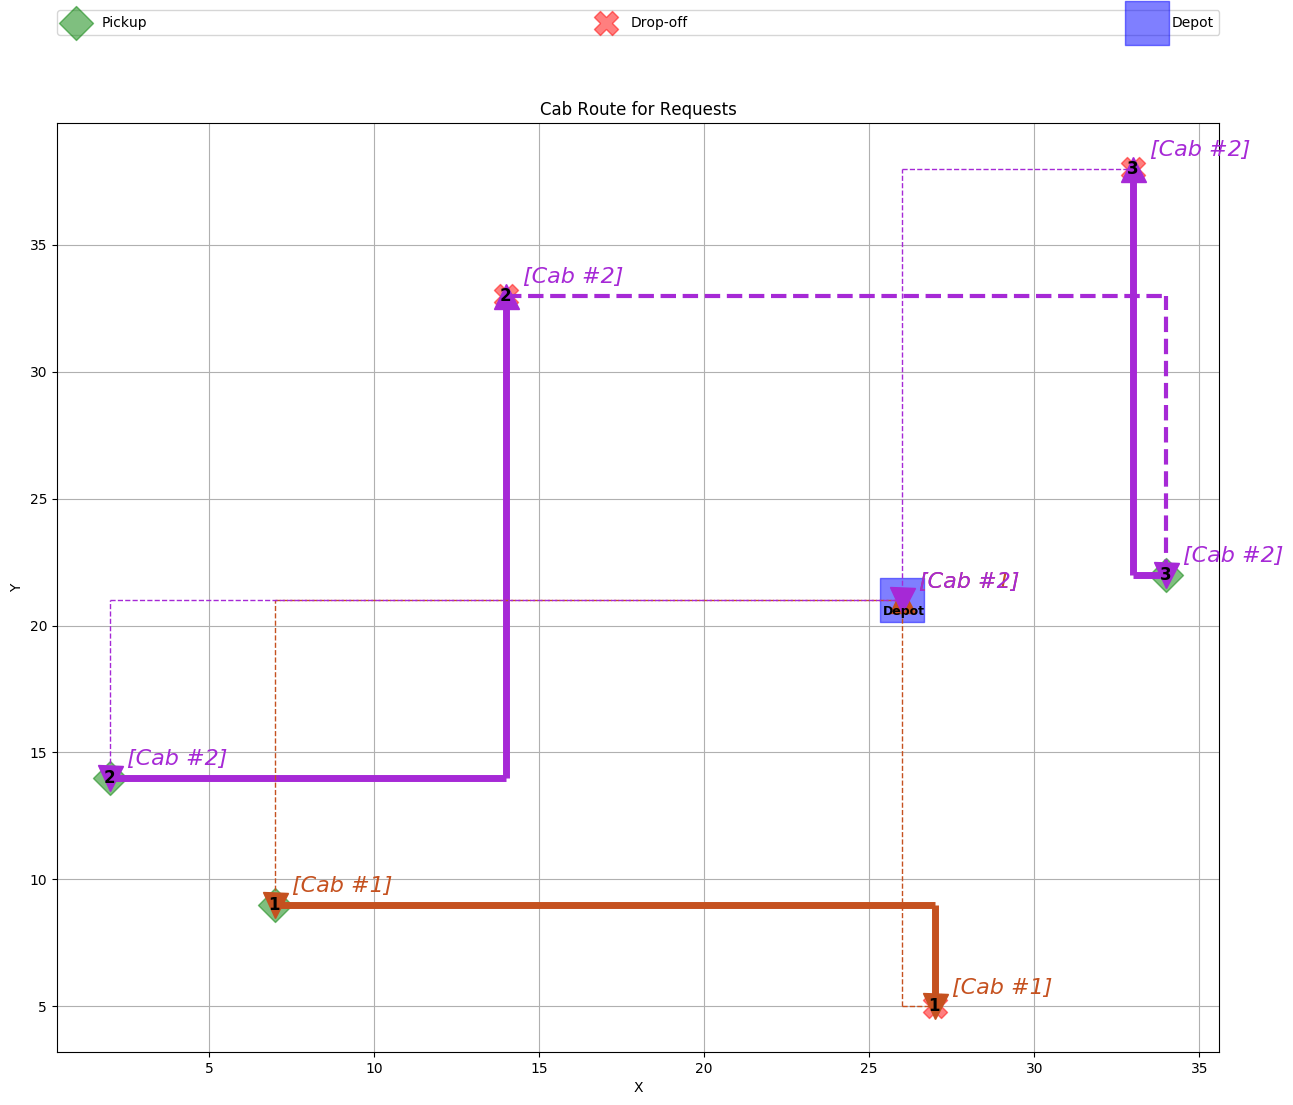

Academic license - for non-commercial use only
  0.015454 seconds (771 allocations: 179.828 KiB)

Optimal solution: 
- objective_best = 20206.0
- y_best = [1.0, 1.0, 0.0]
- x_best = 
[1.0, -0.0, -0.0]
[-0.0, 1.0, -0.0]
[-0.0, 1.0, -0.0]
- d_best = [72.0, 134.0, 0.0]


([1.0, 1.0, 0.0], [72.0, 134.0, 0.0])

In [162]:
lambda = 10000 # Weighting of the cab number for objective
y_best, d_best = optmize_VRP_model(requests, depot, dist_map, p_t, p_l, d_t, d_l, duration, R, K, lambda)